In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Input,Dense,Dropout
from tensorflow.keras.models import Model
import pickle

In [4]:
#Load the dataset after LASSO variable selection

x = pd.read_csv("variable_selection.csv")
y = pd.read_csv("variable_labels.csv")

#Splits the dataset into 70 percent training set and 30 percent testing set
# keeping the random_state value same makes the function to split same rows into training and testing every time
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=30)

In [6]:
#creates 4layer Artificial neural network model as the attributes are very less
inp= Input(shape=(13, ))
x = Dense(64,activation='relu')(inp)
x = Dense(8,activation='relu')(x)
out = Dense(1,activation='linear')(x)
normal_model=Model(inputs=inp,outputs=out)
normal_model.compile('adam','mean_squared_error')

In [13]:
from datetime import timedelta
import time

#Time returns the elapsed time in seconds. This function converts that into hours, minutes and seconds
def convert_to_preferred_format(sec):
   sec = sec % (24 * 3600)
   hour = sec // 3600
   sec %= 3600
   min = sec // 60
   sec %= 60
   return "%02d:%02d:%02d" % (hour, min, sec) 
start = time.time()
normal_model.fit(x_train, y_train,epochs=30,batch_size=128)

normal_predictions = normal_model.predict(x_test)
k=len(list(x_train.columns))
n = len(normal_predictions)
stop = (time.time() - start)

#Calculates and prints the time taken for training the Artificial neural network
print('Elapsed Time:', convert_to_preferred_format(stop))
print('======'*5)
print("Before GridSearchCV")
print('======'*5)

#Evaluation metrics for the unoptimized Artificial neural network on test set
Metrics={}
Metrics['MSE']=[mean_squared_error(y_test,normal_predictions)]
Metrics['RMSE']=[np.sqrt(mean_squared_error(y_test,normal_predictions))]
Metrics['R2_Score']=[r2_score(y_test,normal_predictions)]
Metrics['Adjusted_R2_score']=[1 - ((1-r2_score(y_test,normal_predictions))*(n-1)/(n-k-1))]
metrics_df = pd.DataFrame(Metrics)
print(metrics_df)
normal_model.save('DL_variable_model')

Epoch 1/30
479/479 [==============================] - 2s 3ms/step - loss: 0.1415
Epoch 2/30
479/479 [==============================] - 1s 3ms/step - loss: 0.1252
Epoch 3/30
479/479 [==============================] - 1s 2ms/step - loss: 0.1128
Epoch 4/30
479/479 [==============================] - 1s 2ms/step - loss: 0.1600
Epoch 5/30
479/479 [==============================] - 1s 2ms/step - loss: 0.1225
Epoch 6/30
479/479 [==============================] - 1s 2ms/step - loss: 0.1108
Epoch 7/30
479/479 [==============================] - 1s 2ms/step - loss: 0.1488
Epoch 8/30
479/479 [==============================] - 1s 2ms/step - loss: 0.1076
Epoch 9/30
479/479 [==============================] - 1s 2ms/step - loss: 0.1066
Epoch 10/30
479/479 [==============================] - 1s 2ms/step - loss: 0.1677
Epoch 11/30
479/479 [==============================] - 1s 2ms/step - loss: 0.1187
Epoch 12/30
479/479 [==============================] - 1s 2ms/step - loss: 0.1866
Epoch 13/30
479/479 [====

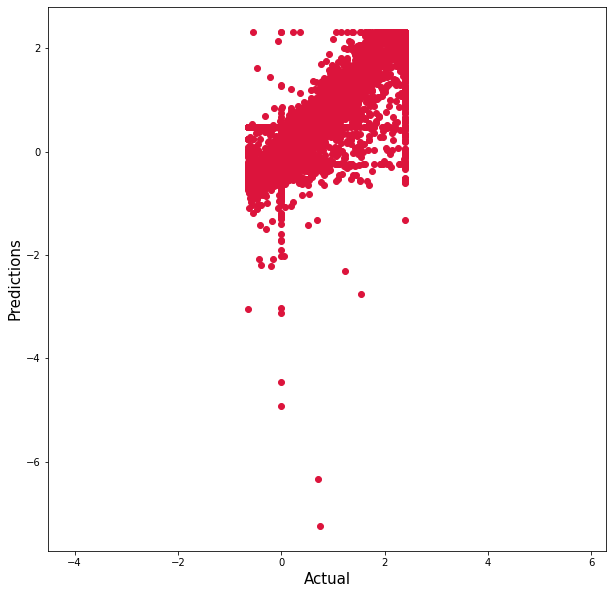

In [14]:
#Plot of actual values versus the predicted values from Artificial neural network
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(y_test, normal_predictions, c='crimson')
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [15]:
# creates a tuner model that can test different hyperparameters on Artificial neural network

import keras_tuner
from tensorflow import keras
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('units', [256,128,64]),
      activation='relu'))
  model.add(keras.layers.Dense(
      hp.Choice('units', [128,64,32]),
      activation='relu'))
  model.add(keras.layers.Dense(1, activation='linear'))
  model.compile(loss='mse')
  return model

In [16]:
#Time returns the elapsed time in seconds. This function converts that into hours, minutes and seconds
def convert_to_preferred_format(sec):
   sec = sec % (24 * 3600)
   hour = sec // 3600
   sec %= 3600
   min = sec // 60
   sec %= 60
   return "%02d:%02d:%02d" % (hour, min, sec) 
start = time.time()

#Initialize keras tuner model by specifying that it should evaluate different parameters
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='loss',
    max_trials=5)
tuner.search(x_train, y_train.values.ravel(), epochs=20)

best_model = tuner.get_best_models()[0]
#Print the best parameters of the model found by keras tuner
print("Best Parameters Found",tuner.get_best_models()[0])


#Performes predictions on the test set using best found Artificial neural network
tuned_pred = best_model.predict(x_test)
k=len(list(x_train.columns))
n = len(tuned_pred)
stop = (time.time() - start)

#Calculates and prints the time taken for training best found Artificial neural network
print('Elapsed Time:', convert_to_preferred_format(stop))
print('======'*5)
print("After GridSearchCV")
print('======'*5)

#Evaluation metrics for the Artificial neural networkon test set
Metrics={}
Metrics['MSE']=[mean_squared_error(y_test,tuned_pred)]
Metrics['RMSE']=[np.sqrt(mean_squared_error(y_test,tuned_pred))]
Metrics['R2_Score']=[r2_score(y_test,tuned_pred)]
Metrics['Adjusted_R2_score']=[1 - ((1-r2_score(y_test,tuned_pred))*(n-1)/(n-k-1))]
metrics_df = pd.DataFrame(Metrics)
print(metrics_df)

#Saves the model so that it can be used for test results comparison
best_model .save('BEST_DL_variations_model')

Best Parameters Found <keras.engine.sequential.Sequential object at 0x7f99f017e520>
821/821 [==============================] - 1s 2ms/step
Elapsed Time: 00:00:03
After GridSearchCV
        MSE      RMSE  R2_Score  Adjusted_R2_score
0  0.127626  0.357249  0.862509           0.862441
